In [1]:
import os
import pprint
import tqdm
import json
import glob
import jsonlines
import pprint
import pandas as pd
import pickle
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import sys
from collections import Counter
import subprocess
import datetime
import h5py
from typing import NamedTuple
import re
import statsmodels.api as sm
from scipy.stats import bernoulli 
from collections import defaultdict
from operator import attrgetter
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix
import networkx as nx

#load in search hashtags
with open('../references/search_hashtags.txt', 'r') as f:
    search_hashtags = f.readlines()
    search_hashtags = [i.replace('\n', '') for i in search_hashtags]
    search_hashtags = [i.replace('#', '') for i in search_hashtags]
    search_hashtags = [i.lower() for i in search_hashtags]
    search_hashtags.remove('وأناكمان')

# Parameters

In [2]:
group_num = 1
hashtag_split = True
ngram_range = '34'
min_user = 100

overwrite = True
read_in = True

# Load in data and basic preprocessing

In [3]:
# Load in data

interactions_hdf5_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/interactions.hdf5'

# check if data was saved in multiple parts
with h5py.File(interactions_hdf5_file, 'r') as f:
    interactions_hdf5_keys = f.keys()
    interactions_hdf5_keys = [i for i in interactions_hdf5_keys if re.search(f'interactions_group_{group_num}_part',i)]
    print(interactions_hdf5_keys)

if len(interactions_hdf5_keys) > 1:
    print('Multi-part interactions read-in')
    list_df = []
    for i in interactions_hdf5_keys:
        list_df.append(pd.read_hdf(interactions_hdf5_file,i))
    df = pd.concat([i for i in list_df], axis=0)
else:
    df = pd.read_hdf(interactions_hdf5_file,f'interactions_group_{group_num}')
    print('data read in')

def convert_in_reply_to(x):
    if x:
        return x[0]
    else:
        return None

print('converting data format for in_reply_to')
df['in_reply_to'] = df['in_reply_to'].apply(convert_in_reply_to)

# remove self replies
print('removing self_replies')
df = df[df['author_id']!=df['in_reply_to']]

def combine_quotes(row):
    if isinstance(row, list):
        return row
    if isinstance(row, str):
        return [str]

# extract quoted tweet ids
print('Extracting quote ids')
df['quotes']= df['quotes'].apply(combine_quotes)
quoted_tweet_ids = []
for row in df.itertuples():
    for tweet_id in row.quotes:
        quoted_tweet_ids.append(tweet_id)
quoted_tweet_ids = list(set(quoted_tweet_ids))

print('saving to file')
# save quotes to group location
group_folder = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/01_raw/0{group_num}_group/'
assert os.path.isdir(group_folder)
hydration_filename = os.path.join(group_folder, 'quoted_hydration.txt')
hydrated_filename = os.path.join(group_folder, 'hydration.jsonl')
with open(hydration_filename, 'w') as f:
    for line in quoted_tweet_ids:
        f.write(line)
        f.write('\n')

['interactions_group_1_part_0', 'interactions_group_1_part_1']
Multi-part interactions read-in
converting data format for in_reply_to
removing self_replies
Extracting quote ids
saving to file


In [4]:
assert os.path.isfile(hydrated_filename)
# collect usernames from hydrated:
quoted_to_user_id = defaultdict(None)
with jsonlines.open(hydrated_filename, 'r') as reader:
    for line in reader:
        for tweet in line['data']:
            quoted_to_user_id[tweet['id']] = tweet['author_id']

def convert_quotes(quote_list, dictionary):

    res = []
    for i in quote_list:
        if i not in dictionary:
            pass
        else:
            res.append(dictionary[i])
    return res

df['quoted_user_id'] = df['quotes'].apply(convert_quotes, args=(quoted_to_user_id,))

non_null = len(df[~df['quoted_user_id'].isnull()])

print(f'Number of non-null: {non_null}')

# get unique counts
df_authors = set(df['author_id'].unique())

print('getting internal counts...')
# generate counts of internal mentions/replies
df['internal'] = (df['in_reply_to'].isin(df['author_id'])) | (df['mentions'].apply(lambda x: any([i in df_authors for i in x]))) | (df['quoted_user_id'].apply(lambda x: any([i in df_authors for i in x])))

internal = df['internal'].sum()
print(f'Internal replies (not self replies): {internal}')
print(f'Total df length: {len(df)}')
user_interaction_counts = df[['author_id','tweet_id']].groupby('author_id').count()

user_interaction_counts.describe()

for hashtag in search_hashtags:
    df['vocab:#'+hashtag] = df['contains_hashtags'].apply(lambda x: any(hashtag.lower() == item.lower() for item in x))


def combine_mention_replies(row):
    res = []
    if row['mentions'] is not None:
        for i in row['mentions']:
            res.append(i)
    if row['quoted_user_id'] is not None:
        for i in row['quoted_user_id']:
            res.append(i)
    if row['in_reply_to'] is not None:
        assert isinstance(row['in_reply_to'],str)
        res.append(row['in_reply_to'])
    return res

# collect users interacted with
df['interacted_users'] = df.apply(combine_mention_replies,axis=1)


Number of non-null: 7939920
getting internal counts...
Internal replies (not self replies): 848558
Total df length: 7939920


In [5]:
df['contains_hashtags']

0                                    []
1                                    []
2                                    []
3                                    []
4                                    []
                       ...             
8581033    [TIMESUP, TheFutureIsFemale]
8581034                       [TIMESUP]
8581035                         [MeToo]
8581036           [13ReasonsWhy, MeToo]
8581037           [13ReasonsWhy, MeToo]
Name: contains_hashtags, Length: 7939920, dtype: object

# Also read in the stats_df for other parametrs like m3_inference

In [6]:
stats_df_save_dir = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/'
save_filename = os.path.join(stats_df_save_dir, f'stats_df_group_{group_num}.obj')

with open(save_filename, 'rb') as f:
    stats_df = pickle.load(f)

In [7]:
stats_df['ht']

0       balancetonporc
1       balancetonporc
2       balancetonporc
3       balancetonporc
4       balancetonporc
             ...      
2721               我也是
2722                私も
2723                私も
2724                나도
2725                나도
Name: ht, Length: 2726, dtype: object

In [8]:
def unit_conv(val):
    return datetime.datetime.strptime('2017-10-16', '%Y-%m-%d') + datetime.timedelta(days=int(val))

def reverse_unit_conv(date):
    return (datetime.datetime.strptime(date, '%Y-%m-%d') - datetime.datetime.strptime('2017-10-16', '%Y-%m-%d')).days

class daterange(NamedTuple):
    start: str
    end: str

#obtain peak times again
with h5py.File('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5', 'r') as f:
    FAS_peaks = f['peak_detections']
    x = f['segments']['selected_ranges'][int(group_num)-1]
    group_date_range = daterange(
        start = x[0].decode(),
        end = x[1].decode()
    )

    group_start_index = reverse_unit_conv(group_date_range.start)
    group_end_index = reverse_unit_conv(group_date_range.end)

    most_prominent_peaks = {}
    for name, h5obj in FAS_peaks.items():

        peak_locations = h5obj['peak_locations']
        peak_locations = [(i,e) for i,e in enumerate(h5obj['peak_locations']) if (unit_conv(e) > datetime.datetime.strptime(group_date_range.start, '%Y-%m-%d')) and (unit_conv(e) < datetime.datetime.strptime(group_date_range.end, '%Y-%m-%d'))]
        peak_indices = [i[0] for i in peak_locations]
        prominences = [element for index, element in enumerate(h5obj['prominences']) if index in peak_indices]
        if len(prominences) == 0:
            continue
        max_prominence = np.argmax(prominences)
        most_prominent_peaks[name] = unit_conv(peak_locations[max_prominence][1])

In [9]:
x = df[df['created_at']==df['created_at'].min()].groupby('author_id').count()['tweet_id']

In [10]:
df.columns.str.startswith('vocab')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False])

In [17]:
class contagion_model(object):
    def __init__(self, df, activity_file, group_date_range, group_num, by_hashtag = True):
        self.df = df
        self.first = True
        self.activity_file = activity_file
        self.date_range_length = (datetime.datetime.strptime(group_date_range.end, '%Y-%m-%d') - datetime.datetime.strptime(group_date_range.start, '%Y-%m-%d')).days + 1
        self.group_num = group_num
        with h5py.File(self.activity_file, 'r') as f:
            # print(f.keys())
            x = f['group_1']['1005675566']['hashtagged'].attrs['feature_order']
            self.ht_row_mapping = x.split(';')
        self.vocab_colnames = self.df.columns.str.startswith('vocab:#')
        self.by_hashtag=by_hashtag

    @staticmethod
    def _date_to_index(date):
        return (date - datetime.datetime.strptime(group_date_range.start, '%Y-%m-%d').date()).days

    def _setup(self):
        self.users = list(df['author_id'].unique())
        self.current_p = defaultdict(float)
        self.date = self.df['created_at'].min()

        # create empty numpy array to store
        self.probabilities = np.zeros(shape=(len(self.users),36,self.date_range_length+1))

    def _update(self):
        if self.first:
            self._setup()
            self.first=False
        date_filter = self.df[self.df['created_at'] == self.date]

        # for row in date_filter.itertuples():
        #     author_index = self.user.index(row.author_id)
        #     # collect rows that have positive vocab:
        #     hashtag_index = self.ht_row_mapping(row.ht)
        interaction_counts = date_filter.groupby('author_id').sum()

        # iterate over vocab columns
        interaction_counts = interaction_counts.loc[:,interaction_counts.columns.str.startswith('vocab:#')]

        # iterate over columns
        for colname, col_content in interaction_counts.iteritems():

            # print(col_content)
            # extract ht from colname
            ht_col = colname[7:]
            ht_index = self.ht_row_mapping.index(ht_col)

            # the column should only have one value as it's the result of a groupby aggregate.
            for author_id, value in col_content.iteritems():
                if value > 0:
                    self.probabilities[self.users.index(author_id), ht_index, self._date_to_index(self.date)] = value
        # print(f'processed {self.date}')
        if self.date == self.df['created_at'].max():
            return False
        else:
            self.date += datetime.timedelta(days=1)
            return True

    def _model_simple_contagion(self, p=0.001, family='bernoulli'):

        self.family=family

        # for bernoulli, assume that each interaction increases probability of tweeting by:
        # P = 1 - (1-p)^k for k
        contin = True
        while contin:
            contin = self._update()


        # read in data from activity file
        # with h5py.File(self.activity_file, 'r') as f:
            # result = activity_file[f'group_{group_num}'][]['hashtagged'][:]

    def _simulate(self):

        if self.family == 'bernoulli':
            distfunc = bernoulli.rvs

        distfunc_v = np.vectorize(distfunc)

        return distfunc_v(self.cumulative_prob)

    def _get_activity(self):

        activity_res = np.zeros(shape=self.probabilities.shape)
        with h5py.File(self.activity_file, 'r') as f:
            for index, user in enumerate(self.users):
                if self.by_hashtag:
                    activity_res[index,:,:] = f[f'group_{group_num}'][user]['hashtagged'][:] 
                else:
                    activity_res[index, :] = np.sum(f[f'group_{group_num}'][user]['hashtagged'][:], axis=0)
        return activity_res

    def _eval_bernoulli(self, p, ht_num=None):

        if self.by_hashtag:
            assert ht_num is not None
        self.cumulative_prob = np.zeros(shape=self.probabilities.shape)

        #iterate over dates
        for i in range(self.probabilities.shape[-1]-1):
            if self.by_hashtag:
                self.cumulative_prob[:,ht_num,i+1] = 1-(1-p)**np.sum(self.probabilities[:,ht_num,:i], axis=1)
            else:
                # sum axis 2 which is the date axis
                self.cumulative_prob[:,:,i+1] = 1-(1-p)**np.sum(self.probabilities[:,:,:i], axis=2)

        if self.by_hashtag:
            eval_sum = (1-(1-p)**self.cumulative_prob[:,ht_num,:])*(self.activity_res[:,ht_num,:]) + ((1-p)**self.cumulative_prob[:,ht_num,:])*(1-self.activity_res[:,ht_num,:])
        else:
            eval_sum = (1-(1-p)**self.cumulative_prob)*(self.activity_res)+((1-p)**self.cumulative_prob)*(1-self.activity_res)
        eval_sum=np.sum(eval_sum)

        return eval_sum

    def fit(self, type='simple'):

        # do the simple contagion calculation
        self._model_simple_contagion()

        # get activity
        self.activity_res = self._get_activity()
        if self.family=='bernoulli':
            self.activity_res = self.activity_res > 1

        # evaluate
        p_values = np.linspace(0.000001, 0.01, 100)
        p_optimisation = []
        if self.by_hashtag:
            for ht_num in range(self.probabilities.shape[1]):
                for p in p_values:
                    p_optimisation.append((
                        p,
                        ht_num,
                        self._eval_bernoulli(p,ht_num)
                    ))
        else:
            for p in p_values:
                p_optimisation.append(self._eval_bernoulli(p))

        # get best result
        if self.by_hashtag:
            best_index = {}
            for ht_num in range(self.probabilities.shape[1]):
                temp = [i for i in p_optimisation if i[1]==ht_num]
                best_index[ht_num] = max(temp, key=lambda x: x[2])
        else:
            best_index = p_optimisation.index(max(p_optimisation))

        return (best_index, p_values, p_optimisation)

        # # simulate using calculated probabilities
        # if self.by_hashtag:
        #     self._eval_bernoulli(p_values[best_index])
        # else:
        #     self._eval_bernoulli(p_values[best_index])
        #     simulated = self._simulate()

        # return (best_index, p_values, p_optimisation, self.activity_res == simulated)



In [18]:
activity_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/activity_counts.hdf5'

model = contagion_model(df, activity_file, group_date_range, group_num,by_hashtag=True)

In [19]:
fit_result = model.fit()

IndexError: index 3599 is out of bounds for axis 0 with size 100

In [36]:
with open('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/05_model_output/01_group/contagion.obj', 'wb') as f:
    pickle.dump(fit_result, f)

# Visualise results

In [38]:
fit_result[2][0]

25796679.999991767

In [37]:
temp = [i for i in fit_result[2] if i[1] == 0]

IndexError: invalid index to scalar variable.

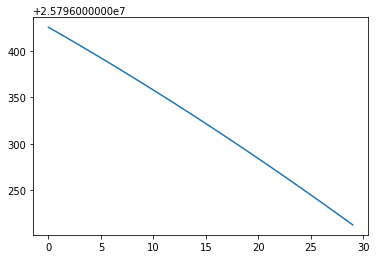

In [31]:
batch = 2
plt.plot(fit_result[2][35*batch:35*batch+34])

In [32]:
len(fit_result[2])

100

In [29]:
fit_result[2][35*batch:35*batch+34]

[]

In [ ]:
fit_result.sum()/(fit_result.shape[0]*fit_result.shape[1])

In [ ]:
fit_result.shape